# `SMRT` class balancing via `AutoEncoder`s

SMRT (Sythetic Minority Reconstruction Technique) is the younger, more sophisticated cousin to SMOTE (Synthetic Minority Oversampling TEchnique). Using variational auto-encoders, SMRT learns the parameters that best reconstruct the observations in each minority class, and then generates synthetic observations until the minority class is represented at a minimum of `balance_ratio` * majority_class_size. 

SMRT avoids one of SMOTE's greatest risks: In SMOTE, when drawing random observations from whose k-nearest neighbors to reconstruct, the possibility exists that a "border point," or an observation very close to the decision boundary may be selected. This could result in the synthetically-generated observations lying too close to the decision boundary for reliable classification, and could lead to the degraded performance of an estimator. SMRT avoids this risk implicitly, as the [`VariationalAutoencoder`](https://github.com/tgsmith61591/smrt/blob/master/smrt/autoencode/autoencoder.py) learns a distribution that is generalizable to the lowest-error (i.e., most archetypal) observations.


__Notebook purpose__:

Using the MNIST dataset (sampled in an imbalanced fashion with only 1s and 0s), this notebook will demonstrate the efficacy of SMRT's reconstructive balancing technique.

In [1]:
from __future__ import division, print_function, absolute_import
import tensorflow as tf
import numpy as np
import smrt

# this is our seed
seed = 42

# show versions for continuity
print("TensorFlow version: %s" % tf.__version__)
print("NumPy version: %s" % np.__version__)
print("SMRT version: %s" % smrt.__version__)

TensorFlow version: 1.0.0
NumPy version: 1.12.1
SMRT version: 0.4-dev


## Load MNIST

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Demonstrate the `AutoEncoder`

Before showing the result of the balancing technique, let's take a look at the `smrt.autoencode.AutoEncoder`. First we will split our data into train and test sets (we will not use the built-in MNIST test data).

In [3]:
# train test split
from sklearn.model_selection import train_test_split

all_data = np.asarray(mnist.train.images)
X_train, X_test = train_test_split(all_data, train_size=0.7, random_state=seed)

X_train.shape

(38500, 784)

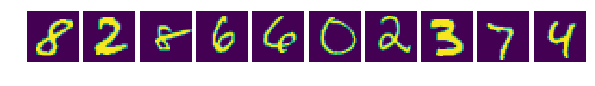

In [4]:
# matplotlib is way too into the whole "warn for everything"
import warnings

def suppress_warnings(func):
    def wrapper(*args, **kwargs):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            return func(*args, **kwargs)
    return wrapper


@suppress_warnings
def show_mnist(array_a, array_b=None, array_c=None, nrow=2, ncol=10, figsize=None, save_loc=None):
    # import without warnings
    from matplotlib import pyplot as plt
    %matplotlib inline
    
    # if both are None, just plot one
    if array_b is None and array_c is None:
        nrow = 1
        
    # if kw specifically makes B None, shift it over
    elif array_b is None:
        array_b = array_c
        array_c = None
        nrow = 2
        
    # otherwise if just plotting the first two...
    elif array_c is None:
        nrow = 2
        
    elif array_b is not None and array_c is not None:
        nrow = 3
        
    if nrow not in (1, 2, 3):
        raise ValueError('nrow must be in (1, 2)')
        
    if figsize is None:
        figsize = (ncol, nrow)
        
    f, a = plt.subplots(nrow, ncol, figsize=figsize)
    arrays = [array_a, array_b, array_c]
    
    def _do_show(the_figure, the_array):
        the_figure.imshow(the_array)
        the_figure.axis('off')
    
    for i in range(ncol):
        if nrow > 1:
            for j in range(nrow):
                _do_show(a[j][i], np.reshape(arrays[j][i], (28, 28)))
        else:
            _do_show(a[i], np.reshape(array_a[i], (28, 28)))
            
        
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    f.show()
    plt.draw()
    
    # if save...
    if save_loc is not None:
        plt.savefig(save_loc)
    
# draw some:
show_mnist(X_train)

## Fit and reconstruct using `AutoEncoder`

An AutoEncoder is a special case of a feed-forward neural network that attempts to learn a compressed feature space of the input tensor, and whose output layer seeks to reconstruct the original input. It is, therefore, a dimensionality reduction technique, on one hand, but can also be used for such tasks as de-noising and anomaly detection. It can be crudely thought of as similar to a "non-linear PCA."

The ``AutoEncoder`` class, as it is intended in ``smrt``, is used to ultimately identify the more minority-class-phenotypical training examples to "jitter" and reconstruct as synthetic training set observations.

In [5]:
from smrt.autoencode import AutoEncoder
from sklearn.metrics import mean_squared_error

# define the estimator. We will use L2 penalty to augment the generalizability of the encoder
ae = AutoEncoder(n_epochs=50, n_hidden=450, learning_rate=0.01, batch_size=256, 
                 display_step=5, activation_function='sigmoid', verbose=2, 
                 random_state=seed, clip=True, l2_penalty=1e-6, 
                 early_stopping=True)

# fit
ae.fit(X_train)

# transform and reconstruct the test images
reconstructed = ae.feed_forward(X_test)

# get the error:
mse = ((X_test - reconstructed) ** 2).sum(axis=1).sum() / X_test.shape[0]
print("\nTest MSE: %.4f" % mse)

Epoch: 1, cost=0.066252, time=3.3952 (sec)
Epoch: 6, cost=0.011274, time=3.5788 (sec)
Convergence reached at epoch 5, stopping early
Optimization complete after 6 epoch(s). Average epoch time: 3.4210 seconds

Test MSE: 6.1505


## Show reconstruction examples:

Top row is canonical; bottom row is reconstructed.

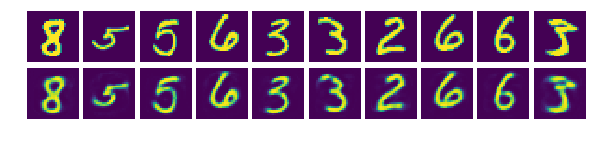

In [6]:
show_mnist(X_test, reconstructed)

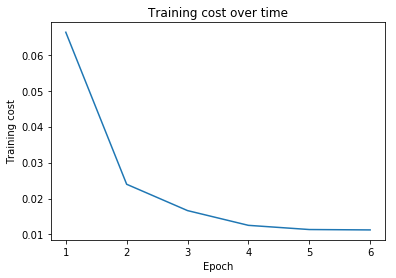

In [7]:
# show training errors
@suppress_warnings
def plot_training_error(estimator):
    # import without warnings
    from matplotlib import pyplot as plt
    %matplotlib inline
    
    c = estimator.epoch_costs_
    plt.plot(np.arange(len(c)) + 1, c)
    plt.title('Training cost over time')
    plt.ylabel('Training cost')
    plt.xlabel('Epoch')
    plt.show()
    
plot_training_error(ae)

*This looks pretty good!* It is illustrative of what a vanilla auto-encoder is capable of: identifying parameters that can be used to reconstruct its input. For data that does not follow the observed/learned patterns, it will have a hard time regenerating the input with a lower error. Notice that the lines on the numbers are a bit blurry. This is a result of the L2 regularization. If you set it to `None` and fit again, you'll notice the bluriness disappears, but you'll be more likely to overfit your neural network.

The entire point of `SMRT` is the ability to create synthetic (never before seen) examples for your imbalanced datasets. The `AutoEncoder`, as shown here, is not a generative model&mdash;that is, it cannot generate new data on its own. However, there is a type of auto-encoder that can do just that: a __variational auto-encoder__.


# What can a `VariationalAutoEncoder` do about imbalance?

Let's create a situation where we have class imbalance (we'll use a dual class example for simplicity - 0/1). We will train a `smrt.autoencode.VariationalAutoEncoder` instance to generate hand-written __ones__ that resemble those in the MNIST dataset.

In [8]:
# they're one-hot encoded right now. Flatten into a single vector
labels = np.asarray([np.argmax(row) for row in mnist.train.labels])
labels

array([7, 3, 4, ..., 5, 6, 8])

## Data prep

Create or load the imbalanced data.

In [9]:
from numpy.random import RandomState
import pickle
import subprocess
import os

rs = RandomState(seed)
fl = 'data/mnist/mnist.pkl'

# can we discern between a 1 and a 7? Might be tough...
min_label = 3
maj_label = 8
minority_size = 1000
majority_size = 100000

def _load_from_pickle():
    with open(fl, 'rb') as f:
        d = pickle.load(f)
        
    X, y = d['data'], d['labels']
    min_mask = y == min_label
    maj_mask = y == maj_label
    
    return X, y, X[min_mask, :], y[min_mask], X[maj_mask, :], y[maj_mask]

# if the pickle is present, load/extract from it
if os.path.exists(fl):
    print('Loading from pickle')
    X, y, X_min, y_min, X_maj, y_maj = _load_from_pickle()
    
# otherwise if the zip file is there
elif os.path.exists(fl + '.zip'):
    print('Loading from zip')
    
    # unzip first
    subprocess.Popen(['unzip', fl + '.zip'])
    X, y, X_min, y_min, X_maj, y_maj = _load_from_pickle()
    
else:
    print('Building dataset')
    
    # create masks
    arng = np.arange(labels.shape[0])
    min_mask = labels == min_label
    maj_mask = labels == maj_label

    # get labels and data
    min_choices = rs.choice(arng[min_mask], minority_size)
    y_min = labels[min_choices]
    X_min = all_data[min_choices, :]

    # get images
    maj_choices = rs.choice(arng[maj_mask], majority_size)
    y_maj = labels[maj_choices]
    X_maj = all_data[maj_choices, :]
        
    X = np.vstack([X_min, X_maj])
    y = np.concatenate([y_min, y_maj])
    
    # pickle it
    output_data = dict(data=X, labels=y)
    with open(fl, 'wb') as od:
        pickle.dump(output_data, od)

    # zip it
    subprocess.Popen(['zip', '-r', '%s.zip' % fl, fl])

# view shapes
print('Minority size: %i' % y_min.shape)
print('Majority size: %i' % y_maj.shape)

Loading from pickle
Minority size: 1000
Majority size: 100000


In [10]:
from sklearn.model_selection import train_test_split

# split high level
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=rs, stratify=y)

# now get the X_ones, X_zeros out of the train...
min_mask = y_train == min_label
maj_mask = ~min_mask

## Observe a `VariationalAutoEncoder`'s generative ability


Before balancing the data, let's look at just what the `VariationalAutoEncoder` is capable of...

In [36]:
from smrt.autoencode import VariationalAutoEncoder

# The cost here is NOT MSE - it's the sum of kullback_leibler + MSE,
# so don't panic that the cost looks so high in relation to the other autoencoder
v_encoder = VariationalAutoEncoder(n_epochs=400, n_hidden=900, n_latent_factors=15, 
                                   learning_rate=0.075, batch_size=256, display_step=25, 
                                   activation_function='sigmoid', verbose=2, l2_penalty=None,
                                   random_state=seed, early_stopping=True, dropout=0.4,
                                   learning_function='sgd', clip=False)

v_encoder.fit(X_train[min_mask, :])

Epoch: 1, cost=415.413849, time=0.2648 (sec)
Epoch: 26, cost=212.407059, time=0.1365 (sec)
Epoch: 51, cost=208.627228, time=0.1440 (sec)
Epoch: 76, cost=201.445602, time=0.1426 (sec)
Epoch: 101, cost=200.926239, time=0.1459 (sec)
Epoch: 126, cost=197.610443, time=0.1483 (sec)
Epoch: 151, cost=189.775650, time=0.1482 (sec)
Epoch: 176, cost=190.967743, time=0.1458 (sec)
Epoch: 201, cost=189.257065, time=0.1489 (sec)
Epoch: 226, cost=180.430878, time=0.1532 (sec)
Epoch: 251, cost=182.200058, time=0.1483 (sec)
Epoch: 276, cost=180.533997, time=0.1491 (sec)
Epoch: 301, cost=182.051102, time=0.1600 (sec)
Epoch: 326, cost=180.776489, time=0.1579 (sec)
Epoch: 351, cost=177.434875, time=0.1508 (sec)
Epoch: 376, cost=178.977478, time=0.1479 (sec)
Optimization complete after 400 epoch(s). Average epoch time: 0.1492 seconds


VariationalAutoEncoder(activation_function='sigmoid', batch_size=256,
            bias_strategy='zeros', clip=False, display_step=25,
            dropout=0.5, early_stopping=True, eps=1e-10, gclip_max=5.0,
            gclip_min=-5.0, l2_penalty=None, layer_type='xavier',
            learning_function='sgd', learning_rate=0.075, min_change=0.001,
            n_epochs=400, n_hidden=900, n_latent_factors=15,
            random_state=42, verbose=2)

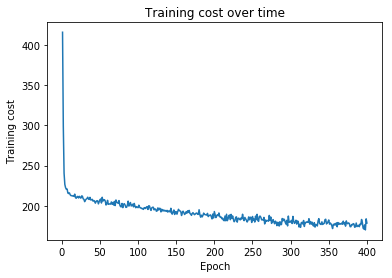

In [37]:
plot_training_error(v_encoder)

In [38]:
# Generate fake data:
fake = v_encoder.generate_from_sample(X_train[min_mask, :][:10])

## Show generation examples

The top row shows some example ones that are __real__, and the second row displays images that are fake, and are created by the variational network after it learns the latent distribution.

Keep in mind that these were generated with only 500 example images, very little regularization and in only 50 epochs.

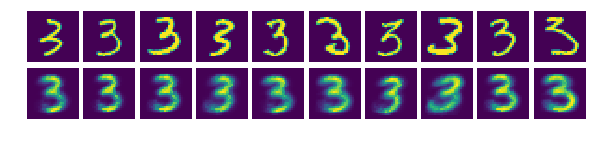

In [39]:
show_mnist(X_train[min_mask, :][:10], fake)

Notice that the generated images are a bit blurry, generalized, and "play it safe," so-to-speak... none of the images denote the crisp character the original images do (or the decorative "tail" on the one). This is because the VAE must learn to generalize the characters.

Now that we've seen what generative models are capable of, let's see how well they can create synthetic examples in the presence of class imbalance

## Perform SMRT balancing

Let's balance our minority class up to a ratio of 50% of the majority class' representation:

In [18]:
from smrt.balance import smrt_balance

# we can balance with the estimator we fit above (if we like it, otherwise SMRT can balance on its own)
X_smrt, y_smrt = smrt_balance(X_train, y_train, n_hidden=900, n_latent_factors=10, random_state=seed, 
                              shuffle=False, balance_ratio=0.5, return_estimators=False, 
                              prefit_estimators={min_label: v_encoder})

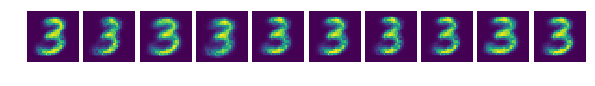

In [19]:
# Let's view some of our synthetically-generated ONEs:
show_mnist(X_smrt[-10:])

# How does `SMRT` stack up to `SMOTE`?

Again, the precept of SMRT is that it avoids one of SMOTE's greatest risks: In SMOTE, when drawing random observations from whose k-nearest neighbors to reconstruct, the possibility exists that a "border point," or an observation very close to the decision boundary may be selected. This could result in the synthetically-generated observations lying too close to the decision boundary for reliable classification, and could lead to the degraded performance of an estimator. SMRT avoids this risk, by ranking observations according to their reconstruction MSE, and drawing samples to reconstruct from the lowest-MSE observations (i.e., the most "phenotypical" of a class).

Thus, we should take a look at how SMOTE & SMRT stack up on the same problem.

In [24]:
from smrt.balance import smote_balance

X_smote, y_smote = smote_balance(X_train, y_train, random_state=seed, n_neighbors=25, 
                                 shuffle=False, balance_ratio=0.5)

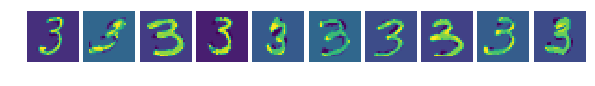

In [25]:
# Let's view some of our perturbed ONEs:
show_mnist(X_smote[-10:])

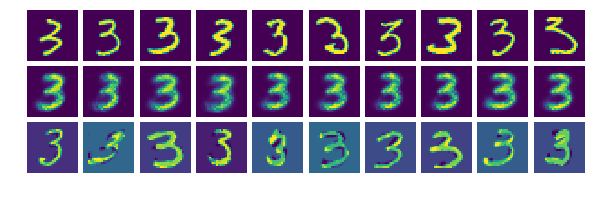

In [26]:
show_mnist(X_train[min_mask, :][:10], X_smrt[-10:], X_smote[-10:], save_loc='img/mnist_smrt_smote.png')

These synthetic examples don't seem to resemble the original dataset as well as SMRT's do. We can't be sure until we test against a classifier, however.

## Fit classifiers against each balanced set:

Our hypothesis is that a classifier should work more accurately and robustly against a dataset balanced using SMRT than by one using SMOTE. Let's see how various models stack up at different ratios of balancing...

In [76]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (precision_score, recall_score, accuracy_score, 
                             f1_score, cohen_kappa_score, roc_auc_score)

# define different smrt args
smrt_kwargs = dict(n_epochs=350, n_hidden=900, n_latent_factors=25, 
                   learning_rate=0.06, batch_size=256, display_step=25, 
                   activation_function='sigmoid', verbose=2, l2_penalty=None,
                   random_state=seed, early_stopping=True, dropout=0.8,
                   learning_function='sgd', clip=False, shuffle=False, 
                   return_estimators=True, prefit_estimators={min_label: v_encoder})

# define different smote args
smote_kwargs = dict(random_state=seed, n_neighbors=25, 
                    shuffle=True, return_estimators=True)

# encode our labels for AUC...
le = LabelEncoder()
le.fit([min_label, maj_label])
y_test_le = le.transform(y_test)
pos_label = le.transform([min_label])[0]

# if pos label is 0, invert it...
def _invert(x):
    return (~x.astype(np.bool)).astype(np.int)

if pos_label == 0:
    y_test_le = _invert(y_test_le)

# function for search
def fit_pred_report(clf, ratios=(0.025, 0.05, 0.075, 0.1, 
                                 0.125, 0.15, 0.175, 0.2, 
                                 0.225, 0.25, 0.275, 0.3,
                                 0.325, 0.35, 0.375, 0.4,
                                 0.425, 0.45, 0.475, 0.5,)):
    print("--- %s ---" % clf.__class__.__name__)
    
    def _fit_pred_report(name, x_tr, y_tr, ratio):
        # make sure to binarize...
        prds = clf.fit(x_tr, y_tr).predict(X_test)
        prds = le.transform(prds)
        
        # ROC requires binary data...
        if pos_label == 0:
            prds = _invert(prds)
        
        # get the scores
        pre = precision_score(y_test_le, prds)
        rec = recall_score(y_test_le, prds)
        acc = accuracy_score(y_test_le, prds)
        f1 = f1_score(y_test_le, prds)
        ck = cohen_kappa_score(y_test_le, prds)
        auc = roc_auc_score(y_test_le, prds)
        
        print("%s val (ratio=%.2f), accuracy=%.3f, precision=%.3f, "
              "recall=%.3f, f1=%.3f, cohen-kappa=%.3f, auc=%.3f" 
              % (name, ratio, acc, pre, rec, f1, ck, auc))
        return pre, rec, acc, f1, ck, auc
        
    # go over each balancer
    performances = {}
    for balancer, nm, kw in ((smote_balance, "SMOTE", smote_kwargs), 
                             (smrt_balance, "SMRT", smrt_kwargs)):
        this_pre, this_rec, this_acc, this_f1, this_ck, this_auc = [], [], [], [], [], []
        performances['%s-precision' % nm] = this_pre
        performances['%s-recall' % nm] = this_rec
        performances['%s-accuracy' % nm] = this_acc
        performances['%s-f1' % nm] = this_f1
        performances['%s-cohen.kappa' % nm] = this_ck
        performances['%s-auc' % nm] = this_auc
        
        # go over ratio levels
        for ratio in ratios:
            x_tr, y_tr, estimators = balancer(X_train, y_train, balance_ratio=ratio, **kw)
            
            # fit the model, get the performance
            pre, rec, acc, f1, ck, auc = _fit_pred_report(nm, x_tr, y_tr, ratio)
            this_pre.append(pre)
            this_rec.append(rec)
            this_acc.append(acc)
            this_f1.append(f1)
            this_ck.append(ck)
            this_auc.append(auc)
        
    print()
    
    output = pd.DataFrame.from_dict(performances)
    output.index = ratios
    return output

The following function will plot the performance of the validation set for varying balancing techniques:

In [124]:
# show validation scores for different balance types
@suppress_warnings
def plot_metric_curves(df, style='darkgrid', linewidth=2, markersize=4, figsize=(15, 10),
                       tgts=('precision', 'recall', 'accuracy', 'auc', 'f1', 'cohen.kappa'),
                       linestyles=('-', ':', '--', '-.'), bal_names=('SMOTE', 'SMRT')):
    # import without warnings
    from matplotlib import pyplot as plt
    import seaborn as sns
    %matplotlib inline
    
    # set style
    sns.set_style(style)
    f, axes = plt.subplots(3, 2, figsize=figsize)
    x_axis = df.index.values
    
    # flatten the axes (from a 3x2 to a 1x6)
    axes = [axis for row in axes for axis in row]
    
    for i, tgt in enumerate(tgts):
        tplt = axes[i]
        mn, mx = 1., 0.  # init inverted so they get updated
        
        # style up the metric name
        metric = ' '.join(tgt.split('.')).title()
        
        for i, nm in enumerate(bal_names):
            bal = nm.split('-')[0]
            y = df['%s-%s' % (nm, tgt)].values
            
            tplt.plot(x_axis, y, label=bal, marker='o', 
                      linestyle=linestyles[i], linewidth=linewidth,
                      markersize=markersize)
            
            tplt.set_ylabel('Validation %s' % metric)
            tplt.legend(loc='lower right')
            
            # update min, max
            mn = min(mn, y.min())
            mx = max(mx, y.max())
            
        # set lim
        tplt.set_ylim((mn - .01, mx + .01))
        
    plt.show()

Now for different algorithms, let's see how we perform...

--- LogisticRegression ---
SMOTE val (ratio=0.03), accuracy=0.998, precision=1.000, recall=0.770, f1=0.870, cohen-kappa=0.869, auc=0.885
SMOTE val (ratio=0.05), accuracy=0.998, precision=1.000, recall=0.800, f1=0.889, cohen-kappa=0.888, auc=0.900
SMOTE val (ratio=0.07), accuracy=0.998, precision=1.000, recall=0.785, f1=0.880, cohen-kappa=0.878, auc=0.893
SMOTE val (ratio=0.10), accuracy=0.998, precision=0.982, recall=0.810, f1=0.888, cohen-kappa=0.887, auc=0.905
SMOTE val (ratio=0.12), accuracy=0.998, precision=0.937, recall=0.815, f1=0.872, cohen-kappa=0.870, auc=0.907
SMOTE val (ratio=0.15), accuracy=0.996, precision=0.803, recall=0.815, f1=0.809, cohen-kappa=0.807, auc=0.906
SMOTE val (ratio=0.17), accuracy=0.995, precision=0.705, recall=0.835, f1=0.764, cohen-kappa=0.762, auc=0.916
SMOTE val (ratio=0.20), accuracy=0.994, precision=0.650, recall=0.855, f1=0.739, cohen-kappa=0.736, auc=0.925
SMOTE val (ratio=0.23), accuracy=0.993, precision=0.608, recall=0.870, f1=0.716, cohen-kappa=

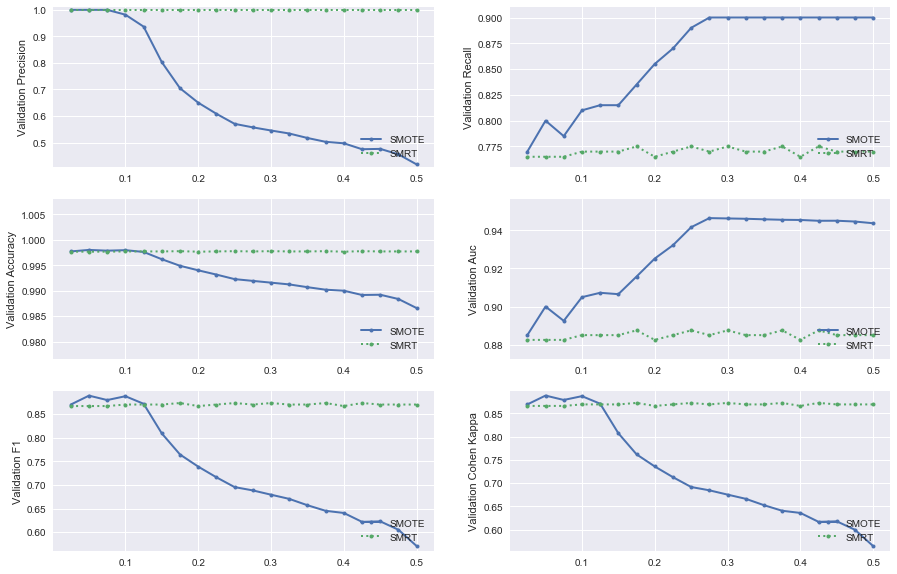

In [126]:
from sklearn.linear_model import LogisticRegression

# logistic regression classifier
lr_performances = fit_pred_report(LogisticRegression(random_state=rs))
plot_metric_curves(lr_performances)

__Asterisks and other acknowledgements__

Yes, the performance margin is *extremely* narrow here. But it's a toy dataset.

__What could improve performance even further?__

SMRT has a *lot* more tuning knobs than SMOTE does. More epochs, lower learning rate, a different activation function, varied dropout rate, regularization... all of the above and more can have a dramatic impact on the reconstructive/generative capability of SMRT.

Furthermore, SMRT requires *__lots__* of data since it's a series of neural networks. Low-rank or small data may perform extremely poorly in the autoencoder (for example, try it on iris...). In these cases, SMOTE may be the preferable option.